interactive(children=(Dropdown(description='precinct_name', options=('001 - CENTRAL', '001 - CHESAPEAKE', '001…

<function __main__.plot_precinct_diagnostics(precinct_name, precinct_gdf, points_gdf, precinct_col='precinctna', bandwidth=None, basemap=True)>

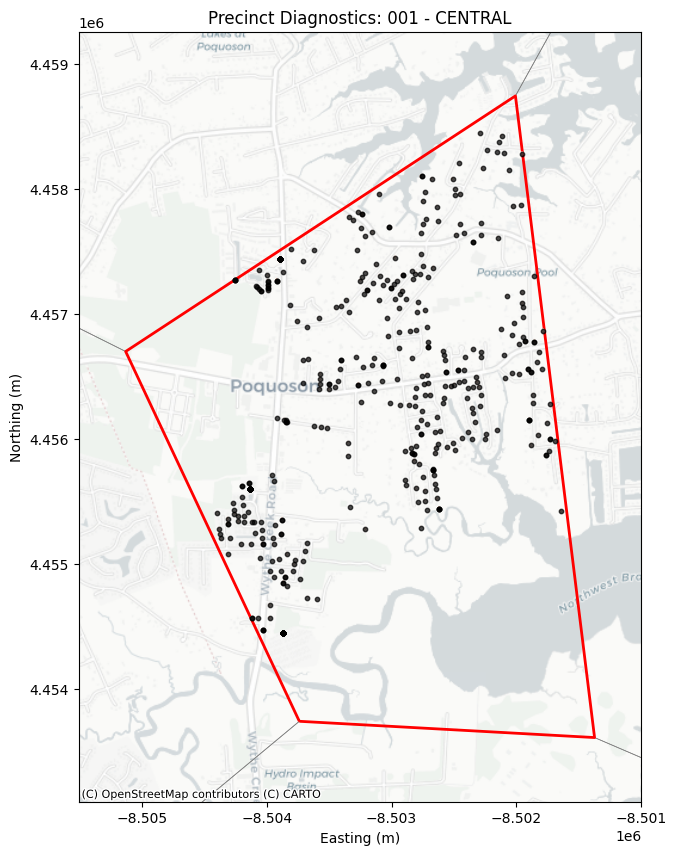

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from ipywidgets import interact, fixed

def plot_precinct_diagnostics(precinct_name, precinct_gdf, points_gdf, precinct_col="precinctna", bandwidth=None, basemap=True):
    # Filter for the selected precinct
    target_precinct = precinct_gdf[precinct_gdf[precinct_col] == precinct_name]
    if target_precinct.empty:
        raise ValueError(f"No precinct found with name {precinct_name}")

    # Get bounding box
    minx, miny, maxx, maxy = target_precinct.total_bounds

    # Points in precinct
    points_in_precinct = points_gdf[points_gdf.within(target_precinct.unary_union)]
    x_coords = points_in_precinct.geometry.x
    y_coords = points_in_precinct.geometry.y

    fig, ax = plt.subplots(figsize=(10,10))
    
    # All precincts
    precinct_gdf.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.5)
    # Highlight selected precinct
    target_precinct.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
    # Points
    ax.scatter(x_coords, y_coords, s=10, color='black', alpha=0.7, zorder=3)
    
    # Plot KDE if possible
    if len(points_in_precinct) > 2 and x_coords.std() > 0 and y_coords.std() > 0:
        sns.kdeplot(
            x=x_coords, y=y_coords,
            fill=True, cmap='Reds',
            alpha=0.5, ax=ax,
            bw_method=bandwidth
        )
    
    # Zoom to precinct
    ax.set_xlim(minx - (maxx - minx)*0.1, maxx + (maxx - minx)*0.1)
    ax.set_ylim(miny - (maxy - miny)*0.1, maxy + (maxy - miny)*0.1)

    # Add basemap
    if basemap and precinct_gdf.crs == "EPSG:3857":
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    ax.set_title(f"Precinct Diagnostics: {precinct_name}")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")

    # Don't call plt.show() here; returning fig will allow Jupyter to display it
    return fig

# Load data
precinct_gdf = gpd.read_file(r"/Users/aspencage/Documents/Data/output/bottom_up_precincts_o/precinct_boundaries_voronoi_241218-1032.shp")
points_df = pd.read_csv(r'/Users/aspencage/Documents/Data/input/post_g2024/bottom_up_precincts_i/va_precinct_lat_long_241212_10M.csv')
points_df = points_df.dropna(subset=["reglongitude", "reglatitude"])

points_gdf = gpd.GeoDataFrame(
    points_df,
    geometry=gpd.points_from_xy(points_df.reglongitude, points_df.reglatitude),
    crs="EPSG:4326"
)

precinct_gdf = precinct_gdf.to_crs(epsg=3857)
precinct_col = "precinctna"
points_gdf = points_gdf.to_crs(epsg=3857)

precinct_list = precinct_gdf[precinct_col].unique().tolist()

# Interact widget
interact(plot_precinct_diagnostics, 
         precinct_name=precinct_list,
         precinct_gdf=fixed(precinct_gdf), 
         points_gdf=fixed(points_gdf), 
         precinct_col=fixed(precinct_col),
         bandwidth=(0.0001, 0.01, 0.0001),
         basemap=True)
